In [186]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import chi2, entropy
from collections import Counter
from typing import NamedTuple, Optional
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import squareform
from scipy.stats import linregress,spearmanr,ttest_ind
import warnings
import seaborn as sb
from matplotlib.patches import Rectangle
from labellines import labelLine, labelLines

from utils import rolling_window, flatten

import vlmc

sb.set_theme(style="ticks", context="paper")

In [187]:
class Rep(NamedTuple):
    tree: vlmc.VLMC
    clan: str
    unit: str

dominica_data = pd.read_csv("Data/dominica_coda_data.csv")
# pacific_data = pd.read_excel('Data/ETP.xlsx')

paper_data = pd.read_csv("Data/pacific_coda_data.csv")
paper_data = paper_data[~paper_data["clan_name"].isna()]
paper_data["year"] = paper_data.date.str[:4]

/home/leitao/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [188]:
def fitVlmc(df, click_col, horizon=1, resolution=0.02, K=None):
    ICIs = df.filter(regex=("^ICI")).values
    nClicks = df[click_col].values
    codas = [coda[: stop - 1] for coda, stop in zip(ICIs, nClicks)]
    discrete_codas, n_bins = vlmc.bin_codas(
        codas, horizon=horizon, resolution=resolution
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tree = vlmc.VLMC(n_bins + 1).fit(discrete_codas, K=K)
    return tree, discrete_codas


def get_D(TREES):
    """
    Given a set of subcoda trees, compute a distace matrix
    """
    D = np.zeros(shape=(len(TREES), len(TREES)))
    for i in range(len(TREES)):
        for j in range(len(TREES)):
            if i == j:
                distance = 0
            else:
                distance = vlmc.distance(TREES[i], TREES[j])
            D[i, j] = distance
    return D


def getV(C, colors, method="average"):
    """
    compute agglomerative clustering and return most
    aesthetic ordering of leaves.
    """
    s = sb.clustermap(
        C,  # np.maximum(quack.C,quack.C.T)
        row_colors=colors,
        method=method,
        row_cluster=True,
        col_cluster=False,
    )
    s.ax_heatmap.remove()
    s.cax.remove()
    V = s.dendrogram_row.linkage
    row_indexes = s.dendrogram_row.reordered_ind
    plt.close()
    return V, row_indexes

def merge_repertoires(clan_name, threshold=300):
    """
    merge pacific repertoires that have less than 300 codas.
    """
    # Load your dataframe into a variable, let's call it df
    df = paper_data[paper_data["clan_name"] == clan_name].copy().reset_index(drop=True)
    df["latitude"] = pd.to_numeric(df["latitude"])
    df["repertoire_name"] = df["grpvar"]

    # main loop
    while True:
        # Count the frequency of each category in the grpvar column
        value_counts = df["repertoire_name"].value_counts()

        # Filter the resulting Series based on the threshold
        small_repertoires = value_counts[value_counts < threshold].index.tolist()
        if len(small_repertoires) < 2:
            break

        N = len(small_repertoires)
        min_distance = np.inf
        for i in range(N):
            lat_x = df[df["repertoire_name"] == small_repertoires[i]].latitude.unique()
            for j in range(i + 1, N):
                lat_y = df[
                    df["repertoire_name"] == small_repertoires[j]
                ].latitude.unique()
                distance = np.min(np.abs(lat_x - lat_y[:, None]))
                if distance >= min_distance:
                    continue
                min_distance = distance
                to_merge = [small_repertoires[i], small_repertoires[j]]

        # Define the values to replace and their replacement
        replacement = f"{to_merge[0]}_{to_merge[1]}"
        # Use replace to replace values in the grpvar column
        df["repertoire_name"] = df["repertoire_name"].replace(to_merge, replacement)
    return df

In [189]:
identity_codas = {
    "PALI": [48, 411, 412, 73, 711, 82, 94, 95, 102],
    "FP": [611, 614],
    "SI": [39, 413, 69],
    "RI": [45, 715],
    "SH": [313],
    "PO": [515, 68, 613, 79, 712, 89],
    "REG": [51, 512, 62, 71, 74, 81, 92, 96, 108],
}

clan_color = {
    "PALI":"#FF7F00",
    "FP":"#CD96CD",#EE4FCB
    "SI":"#5D478B",
    "RI":"#CDAD00",
    "SH":"#B22222",
    "PO":"#436EEE",
    "REG":"#9ACD32",
    "EC1":"#436EEE",
    "EC2":"#9ACD32"
}

# Time resolution

In [ ]:
def getClanTrees(clans,idcodas=True,resolution=0.02):
    """
    Get the subcoda tree for each pacific clan
    """
    coda_condition = paper_data['coda_type'].isin(flatten(identity_codas.values()))
    if not idcodas:
        coda_condition = ~coda_condition
    trees= []
    for clan in clans:
        clan_condition = paper_data['clan_name']==clan
        condition = coda_condition & clan_condition
        tree,_ = fitVlmc(paper_data[condition],click_col='nclicks',resolution=resolution)
        trees.append(tree)
    return trees

def overlapData(idcodas, resolution=0.02):
    """
    Calculating clan distance, making sure it has the same indexes
    as clan ovelap
    """
    overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
    clanTrees = getClanTrees(overlap.columns,idcodas=idcodas,resolution=resolution)
    N = len(clanTrees)
    D = np.empty(shape=(N,N))
    for i in range(N):
        for j in range(N):
            D[i,j]=vlmc.distance(clanTrees[i],clanTrees[j])
    notDiag=~np.eye(N,dtype=bool)
    return overlap.values, D, notDiag #overlap.values[notDiag],D[notDiag]


def plot_overlap(xx,yy,ax=None, ms=None):
    """
    Auxiliary function for plotting overlap
    """
    for i,j in np.ndindex(len(xx),len(xx)):
        if i==j:
            continue
        marker_style = dict(color=clan_color[overlap.columns[i]], linestyle=':', marker='o',
                        markersize=ms, markerfacecoloralt=clan_color[overlap.columns[j]],
                           markeredgewidth=0)
        ax.plot(xx[i,j],yy[i,j],fillstyle="left", **marker_style)


overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
xx, yid, mask = overlapData(idcodas=True)
xx, yNid, mask = overlapData(idcodas=False)

In [211]:
dts = np.linspace(0.01,0.1,19)

In [212]:
data = []
for dt in dts:
    row = {}
    row['dt'] = dt
    xx, yid, mask = overlapData(idcodas=True,resolution= dt)
    slope, intercept, r, p, se = linregress(xx[mask], yid[mask])
    row['id_slope'] = slope
    row['id_p'] = p
    xx, yNid, mask = overlapData(idcodas=False, resolution=dt)
    slope, intercept, r, p, se = linregress(xx[mask], yNid[mask])
    row['Nid_slope'] = slope
    row['Nid_p'] = p
    data.append(row)

In [213]:
data = pd.DataFrame(data)

In [ ]:
mosaic ="""
AAA
AAA
BCD
"""

fig, axs= plt.subplots_mosaic(mosaic=mosaic,figsize=(4, 1.7))



axs.plot(dts,data['id_p'].values, label="ID")
axs.plot(dts,data['Nid_p'].values,label="Non-ID")
axs.hlines(0.05,0.01,0.1,linestyle='--',color='k')
axs.spines[['right', 'top']].set_visible(False)
axs.set_ylabel('P-Value')
axs.set_xlabel('Temporal Resolution $\delta t$')
axs.legend(bbox_to_anchor=(0.8, 0.6),
        title="Codas",
        frameon=False,)
plt.savefig("Figures/supplementary_time_res_significance.pdf", dpi=250, bbox_inches="tight")

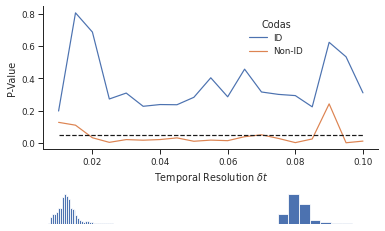

In [350]:
mosaic ="""
AAAAAA
AAAAAA
AAAAAA
AAAAAA
CCCCCC
BBEEDD
"""

fig, axs= plt.subplot_mosaic(mosaic=mosaic,figsize=(6, 4))


axs['B'].bar(np.arange(len(counts0)-2),counts0[:-2],width=1,zorder=-1)
axs['B'].axis("off")
axs['D'].bar(np.arange(len(counts1)-2),counts1[:-2],width=1,zorder=-1)
axs['D'].axis("off")
axs['C'].axis("off")
axs['E'].axis("off")
axs['A'].plot(dts,data['id_p'].values, label="ID")
axs['A'].plot(dts,data['Nid_p'].values,label="Non-ID")
axs['A'].hlines(0.05,0.01,0.1,linestyle='--',color='k')
axs['A'].spines[['right', 'top']].set_visible(False)
axs['A'].set_ylabel('P-Value')
axs['A'].set_xlabel('Temporal Resolution $\delta t$')
axs['A'].legend(bbox_to_anchor=(0.8, 0.6),
        title="Codas",
        frameon=False,)
plt.savefig("Figures/supplementary_time_res_significance.pdf", dpi=250, bbox_inches="tight")

In [327]:
resolution=0.02
ICIs = paper_data.filter(regex=("^ICI")).values
nClicks = paper_data['nclicks'].values
codas = [coda[: stop - 1] for coda, stop in zip(ICIs, nClicks)]
discrete_codas, n_bins = vlmc.bin_codas(
    codas, horizon=1, resolution=resolution
)
inds, counts0 = np.unique(np.concatenate(discrete_codas),return_counts=True)

resolution=0.1
ICIs = paper_data.filter(regex=("^ICI")).values
nClicks = paper_data['nclicks'].values
codas = [coda[: stop - 1] for coda, stop in zip(ICIs, nClicks)]
discrete_codas, n_bins = vlmc.bin_codas(
    codas, horizon=1, resolution=resolution
)
inds, counts1 = np.unique(np.concatenate(discrete_codas),return_counts=True)

(-2.95, 50.95, 0.0, 12650.4)

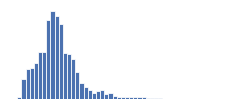

In [328]:
fig, axs= plt.subplots(figsize=(4, 1.7))
plt.bar(np.arange(len(counts0)-2),counts0[:-2],width=1)
axs.axis("off")

In [260]:
bins = np.arange(0, 1 + resolution, resolution)

array([  206,  2698,  4070,  4187,  4964,  6456,  6460, 10805, 12048,
       11397, 10274,  6261,  6065,  5431,  3698,  2159,  1612,  1273,
         855,  1081,  1179,   706,   761,   435,   234,   180,   185,
         258,   301,   284,   226,   152,   126,    99,    50,    24,
          39,    36,    19,    36,    26,    22,    11,    13,     4,
           2,     2,     1,     1, 23556,    27])

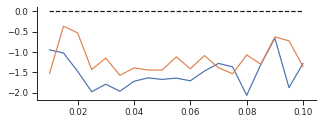

In [218]:
fig, axs= plt.subplots(figsize=(5, 1.7))
axs.plot(dts,data['Nid_slope'].values)
plt.plot(dts,data['id_slope'].values)
axs.hlines(0,0.01,0.1,linestyle='--',color='k')
axs.spines[['right', 'top']].set_visible(False)

# Gaussian mixture

In [97]:
from sklearn.mixture import GaussianMixture
def gaussianFitVlmc(df, click_col,n_bins,K=None):
    ICIs = df.filter(regex=("^ICI")).values
    nClicks = df[click_col].values
    codas = [coda[: stop - 1] for coda, stop in zip(ICIs, nClicks)]
    gm = GaussianMixture(n_components=n_bins).fit(np.concatenate(codas).reshape(-1, 1))
    discrete_codas = [gm.predict(coda.reshape(-1, 1)) for coda in codas]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tree = vlmc.VLMC(n_bins + 1).fit(discrete_codas, K=K)
    return tree, discrete_codas

In [98]:
tree, discrete_codas = tree_gaussian_bins(paper_data,'nclicks',n_bins=5)

Text(0.5, 0, 'ICI')

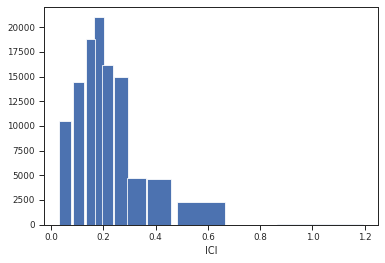

In [101]:
inds, counts = np.unique(np.concatenate(discrete_codas),return_counts=True)
plt.bar(gm.means_.flatten(),counts0,width=np.log(gm.covariances_.flatten()/np.min(gm.covariances_.flatten())+1)/20)
plt.xlabel('ICI')

In [55]:
def gaussianClanTrees(clans,idcodas=True,n_bins=10):
    """
    Get the subcoda tree for each pacific clan
    """
    coda_condition = paper_data['coda_type'].isin(flatten(identity_codas.values()))
    if not idcodas:
        coda_condition = ~coda_condition
    trees= []
    for clan in clans:
        clan_condition = paper_data['clan_name']==clan
        condition = coda_condition & clan_condition
        tree,_ = gaussianFitVlmc(paper_data[condition],click_col='nclicks',n_bins=n_bins)
        trees.append(tree)
    return trees

def gaussianOverlapData(idcodas, n_bins=10):
    """
    Calculating clan distance, making sure it has the same indexes
    as clan ovelap
    """
    overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
    clanTrees = gaussianClanTrees(overlap.columns,idcodas=idcodas,n_bins=n_bins)
    N = len(clanTrees)
    D = np.empty(shape=(N,N))
    for i in range(N):
        for j in range(N):
            D[i,j]=vlmc.distance(clanTrees[i],clanTrees[j])
    notDiag=~np.eye(N,dtype=bool)
    return overlap.values, D, notDiag #overlap.values[notDiag],D[notDiag]

In [111]:
all_bins = np.arange(5,55,5)
gaussianData = []
for n_bins in all_bins:
    row = {}
    row['n_bins'] = n_bins
    xx, yid, mask = gaussianOverlapData(idcodas=True,n_bins=n_bins)
    slope, intercept, r, p, se = linregress(xx[mask], yid[mask])
    row['id_slope'] = slope
    row['id_p'] = p
    xx, yNid, mask = gaussianOverlapData(idcodas=False, n_bins=n_bins)
    slope, intercept, r, p, se = linregress(xx[mask], yNid[mask])
    row['Nid_slope'] = slope
    row['Nid_p'] = p
    gaussianData.append(row)
    
gaussianData = pd.DataFrame(gaussianData)

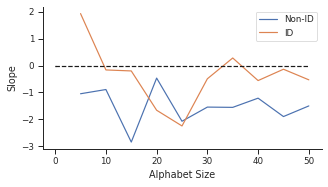

In [102]:
fig, axs= plt.subplots(figsize=(5, 2.6))
axs.plot(all_bins,gaussianData['Nid_slope'].values,label="Non-ID")
plt.plot(all_bins,gaussianData['id_slope'].values,label="ID")
axs.hlines(0,0.01,0.1,linestyle='--',color='k')
axs.spines[['right', 'top']].set_visible(False)
axs.hlines(0,0,50,linestyle='--',color='k')
axs.set_xlabel("Alphabet Size")
axs.set_ylabel("Slope")
plt.legend()

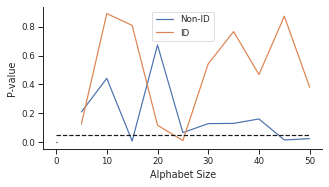

In [103]:
fig, axs= plt.subplots(figsize=(5, 2.6))
axs.plot(all_bins,gaussianData['Nid_p'].values,label="Non-ID")
plt.plot(all_bins,gaussianData['id_p'].values,label="ID")
axs.hlines(0,0.01,0.1,linestyle='--',color='k')
axs.spines[['right', 'top']].set_visible(False)
axs.hlines(0.05,0,50,linestyle='--',color='k')
axs.set_xlabel("Alphabet Size")
axs.set_ylabel("P-value")
plt.legend()

### Noise robustness

In [126]:
def noiseVlmc(df, click_col, horizon=1, resolution=0.02, K=None, scale=6):
    ICIs = df.filter(regex=("^ICI")).values
    nClicks = df[click_col].values
    codas = [coda[: stop - 1] for coda, stop in zip(ICIs, nClicks)]
    #add le noise
    codas = [coda + np.random.normal(loc = 0 , scale = resolution*scale, size=len(coda)) for coda in codas]
    discrete_codas, n_bins = vlmc.bin_codas(
        codas, horizon=horizon, resolution=resolution
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tree = vlmc.VLMC(n_bins + 1).fit(discrete_codas, K=K)
    return tree, discrete_codas

def noiseClanTrees(clans,idcodas=True,resolution=0.02,scale=6):
    """
    Get the subcoda tree for each pacific clan
    """
    coda_condition = paper_data['coda_type'].isin(flatten(identity_codas.values()))
    if not idcodas:
        coda_condition = ~coda_condition
    trees= []
    for clan in clans:
        clan_condition = paper_data['clan_name']==clan
        condition = coda_condition & clan_condition
        tree,_ = noiseVlmc(paper_data[condition],click_col='nclicks',resolution=resolution,scale=scale)
        trees.append(tree)
    return trees

def noiseOverlapData(idcodas, resolution=0.02,scale=6):
    """
    Calculating clan distance, making sure it has the same indexes
    as clan ovelap
    """
    overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
    clanTrees = noiseClanTrees(overlap.columns,idcodas=idcodas,resolution=resolution,scale=scale)
    N = len(clanTrees)
    D = np.empty(shape=(N,N))
    for i in range(N):
        for j in range(N):
            D[i,j]=vlmc.distance(clanTrees[i],clanTrees[j])
    notDiag=~np.eye(N,dtype=bool)
    return overlap.values, D, notDiag #overlap.values[notDiag],D[notDiag]

In [134]:
scales = np.linspace(0,1,11)
noiseData = []
for _ in range(10):
    for scale in scales:
        row = {}
        row['scale'] = scale
        xx, yid, mask = noiseOverlapData(idcodas=True,scale=scale)
        slope, intercept, r, p, se = linregress(xx[mask], yid[mask])
        row['id_slope'] = slope
        row['id_p'] = p
        xx, yNid, mask = noiseOverlapData(idcodas=False, scale=scale)
        slope, intercept, r, p, se = linregress(xx[mask], yNid[mask])
        row['Nid_slope'] = slope
        row['Nid_p'] = p
        noiseData.append(row)

noiseData = pd.DataFrame(noiseData)

In [169]:
1/6

0.16666666666666666

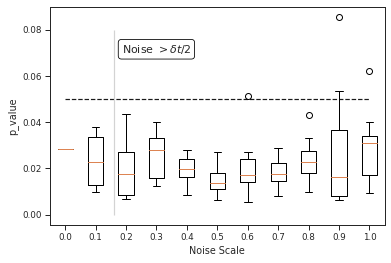

In [183]:
values,positions = [],[]
for scale, frame in noiseData.groupby('scale'):
    positions.append(scale)
    values.append(frame['Nid_p'])

plt.hlines(0.05,0,10,linestyle='--',color='k')
plt.vlines(1.6,0,0.08,color='lightgray')
plt.boxplot(values,positions = np.array(positions)*10)
plt.xticks(np.array(positions)*10,np.round(scales,2))
plt.xlabel("Noise Scale")
plt.ylabel("p_value")
plt.text(3,0.07,"Noise $>\delta t /2$",fontsize=11,bbox=dict(boxstyle="round",fc='white',ec='black'),ha='center')
plt.show()`

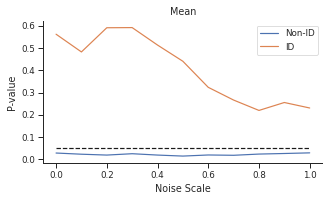

In [184]:
fig, axs= plt.subplots(figsize=(5, 2.6))
axs.plot(scales,noiseData.groupby('scale').mean()['Nid_p'].values,label="Non-ID")
axs.plot(scales,noiseData.groupby('scale').mean()['id_p'].values,label="ID")
axs.spines[['right', 'top']].set_visible(False)
axs.hlines(0.05,0,1,linestyle='--',color='k')
axs.set_xlabel("Noise Scale")
axs.set_ylabel("P-value")
plt.title("Mean")
plt.legend()
plt.show()

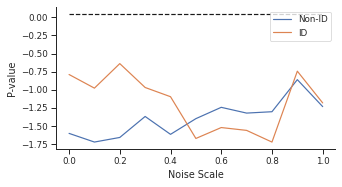

In [133]:
fig, axs= plt.subplots(figsize=(5, 2.6))
axs.plot(scales,noiseData['Nid_slope'].values,label="Non-ID")
plt.plot(scales,noiseData['id_slope'].values,label="ID")
axs.spines[['right', 'top']].set_visible(False)
axs.hlines(0.05,0,1,linestyle='--',color='k')
axs.set_xlabel("Noise Scale")
axs.set_ylabel("P-value")
plt.legend()

In [ ]:
def AIC(tree,discrete_codas,null=False,no_params= False):
    if null:
        log_like = np.sum(np.log([np.product([tree.get_dist(0)[i] for i in sequence]) for sequence in discrete_codas]))
        params = tree.n_params-1
    else:
        log_like = np.sum(np.log([tree.predict(coda) for coda in discrete_codas]))
        params = len(tree.matrix)*(tree.n_params-1)
        
    if no_params:
        return log_like
    return 2*params-2*log_like

In [ ]:
clan = "REG"
aic_vals = []
for dt in dts:
    clan_condition = paper_data['clan_name']==clan
    condition = coda_condition & clan_condition
    tree,discrete_codas = fitVlmc(paper_data[condition],click_col='nclicks',resolution=resolution)
    aic_res=AIC(tree,discrete_codas);aic_null=AIC(tree,discrete_codas,null=True);
    aic_vals.append(np.subtract(aic_res,aic_null))

# Dendogram similarity

In [60]:
def dist_reps(resolution):
    pacific_repertoires = []
    for clan in identity_codas.keys():
        for rep, frame in merge_repertoires(clan).groupby("repertoire_name"):
            if len(frame) < 25:
                continue
            tree, _ = fitVlmc(frame, click_col="nclicks",resolution=resolution)
            pacific_repertoires.append(
                Rep(
                    tree=tree,
                    clan=clan,
                    unit=rep,
                )
            )
    pacific_distances = get_D([r.tree for r in pacific_repertoires])
    return pacific_distances,pacific_repertoires

In [56]:
from sklearn.metrics import adjusted_rand_score
from scipy.cluster import hierarchy
def score_at_height(V,height):
    labels = hierarchy.cut_tree(V, height=height)
    true_labels,pred_labels = [],[]
    for rep,pred_lab in zip(pacific_repertoires,labels.flatten()):
        true_labels.append(rep.clan)
        pred_labels.append(pred_lab)
    return adjusted_rand_score(true_labels,pred_labels)

In [73]:
def similarity_scores(D,repertoires):
    V, row_indexes = getV(np.maximum(D,D.T), [clan_color[r.clan] for r in repertoires])
    heights =np.arange(0,np.max(V[:,2]))
    scores = [score_at_height(V,height) for height in heights]
    return scores

In [76]:
dts = np.linspace(0.01,0.1,19)
similarity = []
for dt in dts:
    pacific_distances,pacific_repertoires = dist_reps(dt)
    scores = similarity_scores(pacific_distances,pacific_repertoires)
    similarity.append(scores)

/home/leitao/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/leitao/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/leitao/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/leitao/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciousl

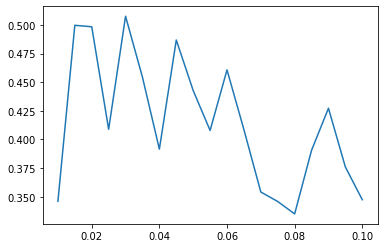

In [79]:
plt.plot(dts,[np.max(score) for score in similarity])

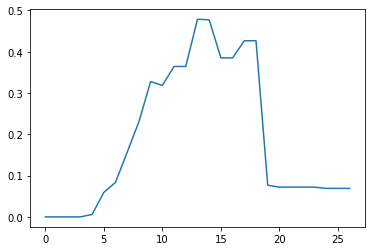

In [75]:
plt.plot(heights,scores)

# coda type

In [148]:
from typing import NamedTuple,Optional

class Clan(NamedTuple):
    name:str
    tree:vlmc.VLMC

class Overlap(NamedTuple):
    clan_x : str 
    clan_y : str
    vlmc_distance:float
    overlap : float

def writeOlsLabel(slope,r,p, sp=None, kp = None):
    s1 = f"slope :  {np.round(slope,4)}\n"
    s2 = f"r2 : {np.round(r,4)}\n"
    s3 = f"p : {np.round(p,4)}"
    if sr is None:
        return s1 + s2 + s3
    s4 = "\n---------\n"
    s5 = f"kendal p : {np.round(kp,4)}\n"
    s6 = f"sprmn p : {np.round(sp,4)}"
    return s1 + s2 + s3 + s4 + s5 +s6

def draw_overlaps(overlaps:list, ax:plt.axis) -> None:
    for overlap in overlaps:
        marker_style = dict(color=clan_color[overlap.clan_x],
                            marker="o",
                            linestyle=':',
                            markersize=9,
                            markerfacecoloralt=clan_color[overlap.clan_y],
                            markeredgewidth=0)
        ax.plot(overlap.overlap,overlap.vlmc_distance,fillstyle="left", **marker_style)
        
        
        
def overlap_by_type(coda:str,id_clans=[]) -> list:
    overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
    clans = []
    coda_condition = paper_data['coda_type']==coda
    for clan in overlap.columns:
        #skip if id clan
        if clan in id_clans:
            continue
        clan_condition = paper_data['clan_name']==clan
        condition = coda_condition & clan_condition
        if len(paper_data[condition])<5:
            continue
        tree,_ = fitVlmc(paper_data[condition],click_col='nclicks')
        clans.append(Clan(name=clan, tree =tree))
    
    overlaps = []
    for clan1 in clans:
        for clan2 in clans:
            if clan1.name==clan2.name:
                continue
            vlmc_distance = vlmc.distance(clan1.tree, clan2.tree)
            ix = overlap.columns.get_loc(clan1.name)
            iy = overlap.columns.get_loc(clan2.name)
            overlaps.append(Overlap(
                clan_x = clan1.name,
                clan_y = clan2.name,
                vlmc_distance = vlmc_distance,
                overlap = overlap.iloc[ix,iy],
            ))
    return overlaps

In [206]:
stats = []
for coda, frame in paper_data.groupby('coda_type'):
    id_clans = [clan for clan in frame['clan_name'].unique() if coda in identity_codas[clan]]
    overlaps = overlap_by_type(coda,id_clans)
    if len(overlaps)<3:
        continue
    slope, intercept, r, p, se = linregress([o.overlap for o in overlaps], [o.vlmc_distance for o in overlaps])
    sr, sp = spearmanr([o.overlap for o in overlaps], [o.vlmc_distance for o in overlaps])
    stats.append(
        {'coda_type':coda,'slope':slope,
         'pearson_p':p,'spearman_p':sp,
         'clans':np.unique([o.clan_x for o in overlaps]),
        'n_clans':np.unique([o.clan_x for o in overlaps]).shape[0]}
    )

In [185]:
df = pd.DataFrame(stats)
# Count the number of negative slopes
negative_slopes = df[df['slope'] < 0]
negative_count = negative_slopes.shape[0]

# Count the number of negative slopes with p-value < 0.1
p_value_threshold_1 = negative_slopes[negative_slopes['pearson_p'] < 0.1]
p_value_1_count = p_value_threshold_1.shape[0]

# Count the number of negative slopes with p-value < 0.05
p_value_threshold_2 = negative_slopes[negative_slopes['pearson_p'] < 0.05]
p_value_2_count = p_value_threshold_2.shape[0]

# Total number of elements
total_count = df.shape[0]

# Creating the bar plot
labels = ['Total','Negative Slope', 'p-value < 0.1', 'p-value < 0.05']
counts = [total_count, negative_count, p_value_1_count, p_value_2_count]
fig, axs= plt.subplots(figsize=(5, 1.7))


barlist = axs.bar(labels, counts,color="#D0DBFB",width=0.6,edgecolor='k',linewidth=1)
barlist[1].set_color(clan_color["EC1"])


axs.set_ylabel('Coda Types')
#axs.set_title('Goegraphical Overlap versus Subcoda Distance')
axs.spines[['right', 'top']].set_visible(False)
plt.savefig("Figures/supplementary_coda_type.pdf", dpi=250, bbox_inches="tight")
plt.savefig("Figures/supplementary_coda_type.png", dpi=250, bbox_inches="tight")
plt.show()

NameError: name 'stats' is not defined

In [205]:
df[['coda_type','slope','pearson_p','spearman_p','n_clans']]

,coda_type,slope,pearson_p,spearman_p,n_clans
0,33.0,-0.352894,0.864120,0.787172,3
1,34.0,-0.943527,0.257211,0.050266,4
2,35.0,-6.021979,0.031132,0.031659,5
3,42.0,-4.098461,0.004497,0.010047,7
4,43.0,-0.615171,0.595790,0.572863,4
5,45.0,-1.326652,0.266219,0.207232,5
6,47.0,-5.807828,0.628062,0.699798,3
7,48.0,9.818289,0.257520,0.257369,3
8,49.0,10.481454,0.371373,0.537901,3
9,51.0,-0.938869,0.634211,0.695484,6
